### École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> 
# <center> TP2 INF8460 <br>  Automne 2021 </center>

## 1. DESCRIPTION
Le but de ce TP est de comparer différents classificateurs que vous allez entraîner à reconnaitre le genre (masculin, féminin) d'un blogueur.

## 2. LIBRAIRIES PERMISES
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- Keras

Pour toute autre librairie, demandez à votre chargé de laboratoire via le forum du cours sur Moodle.

## 3. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)
- Vous pouvez aussi utiliser l’environnement Google Colab: https://colab.research.google.com/

## 4. DESCRIPTION DES DONNEES

Plusieurs fichiers au format csv sont disponibles et sont extraits de blogs échangés sur Blogger.com. Les données sont disponibles dans le répertoire data. 

Elles ont la forme suivante:
- Train: contient 7 000 exemples de blogs écrits par des hommes et des femmes
- Val: contient 1 000 exemples
- Test: contient 2 000 exemples

## 5. ETAPES DU TP 
À partir du présent notebook inf8460_A21_TP2, vous devez réaliser les étapes suivantes. (Noter que les cellules sont là à titre informatif, il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

Ci-dessous définir la constante _PATH_ qui doit être utilisée par votre code pour accéder aux fichiers. Il est attendu que pour la correction, le chargé de lab n'ait qu'à changer la valeur de _PATH_ pour le répertoire où se trouver les fichiers de datasets.

In [1]:
import pandas as pd
import numpy as np
import nltk as nl
import sklearn as sk
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.pipeline import Pipeline

from scipy import sparse

import re as re
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import matplotlib.pyplot as plt
nl.download("punkt")
nl.download("stopwords")
nl.download('wordnet')
stop_words = set(stopwords.words('english'))
# PATH = "drive/MyDrive/data/TP2/"
PATH = "NLP_INF8460/TP2/Squelette et données/data/"

[nltk_data] Downloading package punkt to C:\Users\Pierre-
[nltk_data]     LucBoivin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Pierre-
[nltk_data]     LucBoivin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Pierre-
[nltk_data]     LucBoivin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

train = pd.read_csv(PATH+'train.csv')
valid = pd.read_csv(PATH+'valid.csv')
test = pd.read_csv(PATH+'test.csv')
train.head(10)

,id,gender,topic,text
0,883178,male,Fashion,I Think I'm Going to Hyperventilat...
1,1103575,female,indUnk,I blogged out on xanga... silly Rachel....
2,4192173,male,Technology,Literally. As I type this at 4:40...
3,883178,male,Fashion,Don't Buy a Skirt on Sale So I g...
4,649790,female,indUnk,New Silly Song ahead... The sun...
5,766556,female,indUnk,Any excuse for a party I was up late ...
6,2844168,female,Marketing,'How many times can this 'flop' flip...
7,3176411,male,Engineering,urlLink mythtv utilities
8,589736,male,Technology,"Well, I guess I have a more updated..."
9,589736,male,Technology,urlLink useful advice


### 5.1. prétraitement et description des données (10%)

1. (4 points) Effectuez le pré-traitement suivant sur le champ *text*: convertir le texte en minuscules, supprimer les stopwords et gardez les signes de ponctuation.

In [3]:
def preprocess(sentences):
  results = []
  for sentence in sentences:
    result = re.sub("[^\w\s!\"#$%&'*,-.:;?@]", '', sentence)
    results.append(result.lower())
  return results

def tokenize(preprocessed_sentences):
  return [word_tokenize(sentence) for sentence in preprocessed_sentences]

def remove_stopwords(tokenized_sentences):
  filtered = []
  for sentence in tokenized_sentences:
    filtered.append([word for word in sentence if word not in stop_words])
  return filtered

In [4]:
train['preprocessed'] = preprocess(train['text'])
test['preprocessed'] = preprocess(test['text'])
valid['preprocessed'] = preprocess(valid['text'])

In [5]:
train['tokenized'] = tokenize(train['preprocessed'])
test['tokenized'] = tokenize(test['preprocessed'])
valid['tokenized'] = tokenize(valid['preprocessed'])

In [6]:
train['no_stopwords'] = remove_stopwords(train['tokenized'])
test['no_stopwords'] = remove_stopwords(test['tokenized'])
valid['no_stopwords'] = remove_stopwords(valid['tokenized'])


In [7]:
train.head()

,id,gender,topic,text,preprocessed,tokenized,no_stopwords
0,883178,male,Fashion,I Think I'm Going to Hyperventilat...,i think i'm going to hyperventilat...,"[i, think, i, 'm, going, to, hyperventilate, i...","[think, 'm, going, hyperventilate, found, tick..."
1,1103575,female,indUnk,I blogged out on xanga... silly Rachel....,i blogged out on xanga... silly rachel....,"[i, blogged, out, on, xanga, ..., silly, rache...","[blogged, xanga, ..., silly, rachel, .]"
2,4192173,male,Technology,Literally. As I type this at 4:40...,literally. as i type this at 4:40...,"[literally, ., as, i, type, this, at, 4:40, a....","[literally, ., type, 4:40, a.m., tuesday, ,, b..."
3,883178,male,Fashion,Don't Buy a Skirt on Sale So I g...,don't buy a skirt on sale so i g...,"[do, n't, buy, a, skirt, on, sale, so, i, go, ...","[n't, buy, skirt, sale, go, urllink, anthropol..."
4,649790,female,indUnk,New Silly Song ahead... The sun...,new silly song ahead... the sun...,"[new, silly, song, ahead, ..., the, sun, 's, s...","[new, silly, song, ahead, ..., sun, 's, shing,..."


2. (3 points) Calculez les statistiques suivantes: Nombre total de types; Nombre total de types/genre; top 20 des types les plus fréquents par genre (male/female).

In [8]:
def count_types(text):
  total_count = 0
  for sentence in text :
    _, count = np.unique(sentence, return_counts=True)
    total_count += len(count)
  return total_count

def topUsed(text):
  dict = {}
  for sentence in text :
    words, count = np.unique(sentence, return_counts=True)
    for i, word in enumerate(words):
      if word not in dict:
        dict[word] = 1
      else:
        dict[word] +=count[i]
  return dict


In [9]:
male_text = train.loc[train.gender == 'male']
female_text = train.loc[train.gender == 'female']
print('Nombre total de types:',count_types(train['no_stopwords']))
print('Nombre de types utilisés par les hommes:', count_types(male_text['no_stopwords']))
print('Nombre de types utilisés par les femmes:', count_types(female_text['no_stopwords']))
top_male = topUsed(male_text['no_stopwords'])
print('Top 20 types les plus fréquents pour les hommes:',sorted(top_male, key=top_male.get, reverse=True)[:20])
top_female = topUsed(female_text['no_stopwords'])
print('Top 20 types les plus fréquents pour les femmes:',sorted(top_female, key=top_female.get, reverse=True)[:20])

Nombre total de types: 496445
Nombre de types utilisés par les hommes: 269636
Nombre de types utilisés par les femmes: 226809
Top 20 types les plus fréquents pour les hommes: ['.', ',', "'s", "'", '?', '...', '!', "n't", ':', 'like', 'one', "'m", ';', '-', 'would', 'get', 'time', '&', 'know', 'urllink']
Top 20 types les plus fréquents pour les femmes: ['.', ',', '!', '...', "'s", "n't", '?', "'", ';', "'m", '&', 'like', '..', 'nbsp', ':', 'one', 'know', 'really', 'get', 'urllink']


3. (3 points) Dans deux figures séparées, affichez la distribution des sujets (topics) en termes de fréquence pour les hommes (male) et les femmes (female).

In [10]:
male_topics = topUsed(male_text['topic'])
female_topics = topUsed(female_text['topic'])

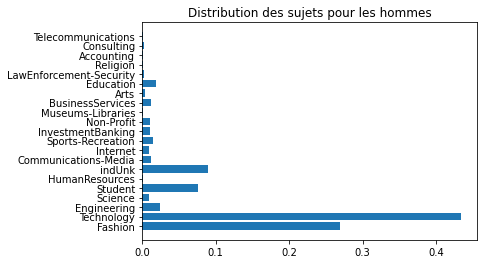

In [11]:
fig, ax = plt.subplots()
y = range(len(male_topics.keys()))
ax.barh(y, [v/len(male_text) for v in male_topics.values()])
ax.set_yticks(y)
ax.set_yticklabels(male_topics.keys())
ax.set_title('Distribution des sujets pour les hommes')
plt.show()

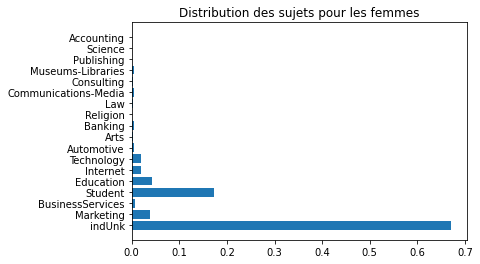

In [12]:
fig, ax = plt.subplots()
y = range(len(female_topics.keys()))
ax.barh(y, [v/len(female_text) for v in female_topics.values()])
ax.set_yticks(y)
ax.set_yticklabels(female_topics.keys())
ax.set_title('Distribution des sujets pour les femmes')
plt.show()

### 5.2. Classification traditionnelle à base de textes (35%)

1. (10 points) Implémentez un classificateur Naïve Bayes et de régression logistique avec sklearn se basant sur un modèle sac de mots unigrame du contenu des blogues, pondéré avec TF-IDF.

In [13]:
def pickler(variable,filename):
  with open(filename + '.pickle', 'wb') as handle:
    pickle.dump(variable, handle, protocol=pickle.HIGHEST_PROTOCOL)

def unpickler(filename):
  with open(filename + '.pickle', 'rb') as handle:
      return pickle.load(handle)

In [14]:
train_join = []
for line in train['no_stopwords']:
  train_join.append(' '.join(line))

test_join = []
for line in test['no_stopwords']:
  test_join.append(' '.join(line))

valid_join = []
for line in valid['no_stopwords']:
  valid_join.append(' '.join(line))

corpus = train_join + test_join + valid_join
# corpus = train_purged_join

In [15]:
le = sk.preprocessing.LabelEncoder()
le.fit(train['topic'])
train_labels = le.transform(train['topic'])
possible_classes = le.transform(le.classes_)

In [16]:
tfidf_1_vec = TfidfVectorizer(ngram_range=(1,1)).fit(corpus)

uni_features = tfidf_1_vec.transform(train_join)
NB1 = MultinomialNB().fit(uni_features,train_labels)
LR1 = LogisticRegression(max_iter=1000).fit(uni_features,train_labels)

2. (10 points) Implémentez un classificateur Naïve Bayes et de régression logistique avec sklearn se basant sur un modèle sac de mots unigrame **et** bigramme du contenu des blogues, pondéré avec TF-IDF.

In [17]:
tfidf_2_vec = TfidfVectorizer(ngram_range=(1,2)).fit(corpus)

unibi_features = tfidf_2_vec.transform(train_join)
NB2 = MultinomialNB().fit(unibi_features,train_labels)
LR2 = LogisticRegression(max_iter=1000).fit(unibi_features,train_labels)

In [18]:
pickler(NB1,PATH + 'NB1')
pickler(NB2,PATH + 'NB2')
pickler(LR1,PATH + 'LR1')
pickler(LR2,PATH + 'LR2')

3. (5 points) Testez vos deux modèles et retournez les valeurs des métriques d’évaluation: précision globale (accuracy) et précision, rappel et F1-score par classe. Affichez aussi les macro moyennes pour toutes ces métriques.

In [19]:
y_test = le.transform(test['topic'])

test_set = []
for line in test['no_stopwords']:
  test_set.append(' '.join(line))

X1_test = tfidf_1_vec.transform(test_set)
X2_test = tfidf_2_vec.transform(test_set)

NB1_pred = NB1.predict(X1_test)
NB2_pred = NB2.predict(X2_test)

LR1_pred = LR1.predict(X1_test)
LR2_pred = LR2.predict(X2_test)

In [20]:
print('---------------------------------------')
print('Performances modèle sac de mots unigrame')
print(' ')
print('Classificateur Naïve Bayes')
print("Précision Globale:",metrics.accuracy_score(y_test, NB1_pred))
print("Précision:",metrics.precision_score(y_test, NB1_pred,average='weighted'))
print("Rappel:",metrics.recall_score(y_test, NB1_pred,average='weighted'))
print("F1-score:",metrics.f1_score(y_test, NB1_pred,average='weighted'))
print(' ')
print('Classificateur Régression Logistique')
print("Précision Globale:",metrics.accuracy_score(y_test, LR1_pred))
print("Précision:",metrics.precision_score(y_test, LR1_pred,average='weighted'))
print("Rappel:",metrics.recall_score(y_test, LR1_pred,average='weighted'))
print("F1-score:",metrics.f1_score(y_test, LR1_pred,average='weighted'))

print('---------------------------------------')

print('Performances modèle sac de mots unigrame et bigramme')
print(' ')
print('Classificateur Naïve Bayes')
print("Précision Globale:",metrics.accuracy_score(y_test, NB2_pred))
print("Précision:",metrics.precision_score(y_test, NB2_pred,average='weighted'))
print("Rappel:",metrics.recall_score(y_test, NB2_pred,average='weighted'))
print("F1-score:",metrics.f1_score(y_test, NB2_pred,average='weighted'))
print(' ')
print('Classificateur Régression Logistique')
print("Précision Globale:",metrics.accuracy_score(y_test, LR2_pred))
print("Précision:",metrics.precision_score(y_test, LR2_pred,average='weighted'))
print("Rappel:",metrics.recall_score(y_test, LR2_pred,average='weighted'))
print("F1-score:",metrics.f1_score(y_test, LR2_pred,average='weighted'))

print('---------------------------------------')



---------------------------------------
Performances modèle sac de mots unigrame
 
Classificateur Naïve Bayes
Précision Globale: 0.428
Précision: 0.5255191572196057
Rappel: 0.428
F1-score: 0.33130180116074215
 
Classificateur Régression Logistique
Précision Globale: 0.6285
Précision: 0.6052729556968414
Rappel: 0.6285
F1-score: 0.5802466913343401
---------------------------------------
Performances modèle sac de mots unigrame et bigramme
 
Classificateur Naïve Bayes
Précision Globale: 0.384
Précision: 0.5369811430843014
Rappel: 0.384
F1-score: 0.25946723614327244
 
Classificateur Régression Logistique
Précision Globale: 0.588
Précision: 0.6212077432588515
Rappel: 0.588
F1-score: 0.5185561293707905
---------------------------------------


c:\users\pierre-lucboivin\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\pierre-lucboivin\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\pierre-lucboivin\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\pierre-lucboivin\anaconda3\e

4. (10 points) Trouvez les paramètres optimaux en utilisant un pipeline et GridSearch. Retournez la configuration optimale et sa performance pour chaque algorithme (Naive Bayes, Régression logistique) avec cette configuration en testant les paramètres suivants: 
- Modèle basé sur les mots ou les caractères
- Type de n-gramme (1, 2 et leur combinaison) 
- Utilisation ou non de TF-IDF
- Minuscule avec TF-IDF ou non
- Taille du vocabulaire: 5000, 10000, none
- Pour Naive Bayes, testez différentes valeurs du paramètre alpha (bayes__alpha)
- Pour la régression logistique, testez aussi différentes stratégies de régularisation (logistic_penalty)

In [ ]:
pipe = Pipeline(steps=[('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

param_grid = {'tfidf__analyzer': ['word','char'],
              'tfidf__ngram_range' : [(1,1), (1,2), (2,2)],
              'tfidf__use_idf' : [True, False],
              'tfidf__lowercase': [True,False],
              'tfidf__max_features' : [5000,10000,None],
              'nb__alpha': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(pipe, param_grid, refit = True, verbose = 3,n_jobs=-1) 
grid.fit(train['text'], train_labels) 
NB_best_params = grid.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   59.6s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.5min


KeyboardInterrupt: ignored

In [ ]:
pipe = Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

param_grid = {'tfidf__analyzer': ['word','char'],
              'tfidf__ngram_range' : [(1,1), (1,2), (2,2)],
              'tfidf__use_idf' : [True, False],
              'tfidf__lowercase': [True,False],
              'tfidf__max_features' : [5000,10000,None],
              'lr__penalty': ['l1', 'l2', 'elasticnet', 'none']}

grid = GridSearchCV(pipe, param_grid, refit = True, verbose = 3,n_jobs=-1) 
grid.fit(train['text'], train_labels) 
LR_best_params = grid.best_params_

### 5.3. Classification neuronale (45%)

1. (10 points) Implémentez un modèle à deux couches Bi-LSTM avec Keras sans plongements pré-entrainés et entrainez-le sur l’ensemble d’entrainement (voir les points suivants). Assurez-vous que votre séquence maximale prenne en compte la plus longue séquence de votre ensemble de données d’entrainement.

In [8]:
df = train.copy()
df = df.append(valid.copy())

# df = df.reset_index(drop=True)
# REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# STOPWORDS = set(stopwords.words('english'))

# def clean_text(text):
#     """
#         text: a string
        
#         return: modified initial string
#     """
#     text = text.lower() # lowercase text
#     text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#     text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = text.replace('x', '')
# #    text = re.sub(r'\W+', '', text)
#     text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
#     return text

# df['text'] = df['text'].apply(clean_text)
# df['text'] = df['text'].str.replace('\d+', '')
# df['text'] = df['text'].str.replace('urllink', '')




In [9]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
# MAX_SEQUENCE_LENGTH = 0
# for line in df['no_stopwords']:
#   if len(line) > MAX_SEQUENCE_LENGTH:
#     MAX_SEQUENCE_LENGTH = len(line)

MAX_SEQUENCE_LENGTH = 250

# This is fixed.
EMBEDDING_DIM = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['no_stopwords'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 54997 unique tokens.


In [10]:
X = tokenizer.texts_to_sequences(df['no_stopwords'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8000, 250)


In [11]:
Y = pd.get_dummies(df['topic']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (8000, 26)


In [20]:
X_train = X[0:7000]
X_test = X[7000:8000]

Y_train = Y[0:7000]
Y_test = Y[7000:8000]

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7000, 250) (7000, 26)
(1000, 250) (1000, 26)


In [21]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(26, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

2. (2 points) Effectuez un «EarlyStopping» prenant en compte une «val_loss» minimale et en attendant 3 époques.

In [22]:
cp_callback = ModelCheckpoint(filepath=PATH+'checkpoint_5_3_2', save_weights_only=True,monitor='val_acc',mode='max',save_best_only=True)
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, Y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), cp_callback])


Train on 7000 samples, validate on 1000 samples
Epoch 1/5
7000/7000 [==============================] - 83s 12ms/sample - loss: 2.0440 - acc: 0.3297 - val_loss: 1.7364 - val_acc: 0.3900
Epoch 2/5
7000/7000 [==============================] - 82s 12ms/sample - loss: 1.6770 - acc: 0.4564 - val_loss: 1.5085 - val_acc: 0.4930
Epoch 3/5
7000/7000 [==============================] - 82s 12ms/sample - loss: 1.2777 - acc: 0.6230 - val_loss: 1.3850 - val_acc: 0.5620
Epoch 4/5
7000/7000 [==============================] - 82s 12ms/sample - loss: 0.9007 - acc: 0.7479 - val_loss: 1.4615 - val_acc: 0.5540
Epoch 5/5
7000/7000 [==============================] - 81s 12ms/sample - loss: 0.6807 - acc: 0.8044 - val_loss: 1.5778 - val_acc: 0.5600


3. (2 points) En utilisant un ModelCheckpoint, sauvegardez votre meilleur modèle pour lequel la métrique «val_accuracy» soit maximale.

In [24]:
# Referer a la question precedente
model.load_weights(PATH+'checkpoint_5_3_2')


4. (5 points) Affichez dans une figure la fonction de perte / époque sur le jeu de données d’entrainement (train) et de validation (val). Voir l'énoncé pour un exemple de figure.

5. (5 points) Affichez dans une figure la précision globale (accuracy)/ époque sur le jeu de données d’entrainement (train) et de validation (val). Voir l'énoncé pour un exemple de figure.

6. (2 points) Chargez le meilleur modèle retenu, et affichez les performances de ce meilleur modèle sur l’ensemble de test. Utilisez la métrique Accuracy. (Exemple: Accuracy: 0.82)

7. (10 points) En utilisant des plongements lexicaux pré-entrainés GLOVE, implémentez un modèle Bi-LSTM à deux couches avec Keras utilisant ces plongements et avec les mêmes critères d’EarlyStopping et de ModelCheckpoint que précédemment, et entrainez-le sur l’ensemble d’entrainement. Sauvegardez votre meilleur modèle. 

8. (2 points) De la même manière que précédemment, affichez dans deux figures la fonction de perte et la précision globale (accuracy) / époque sur le jeu de données d’entrainement (train) et de validation (val).

9. (2 points) Affichez les performances de votre meilleur modèle à base de plongements sur l’ensemble de test. Utilisez la métrique de précision globale (Accuracy).

10. (5 points) Si ce n’est pas déjà le cas, tentez de dépasser les performances de votre meilleur modèle traditionnel en créant un nouveau modèle Bi-LSTM (vous pouvez ajouter des couches, utiliser du dropout, utiliser d’autres modèles de plongements, etc.)

### 5.4. Évaluation (10%)

1. (4 points) Affichez une table récapitulative comparant les performances de vos différents modèles sur l’ensemble de test.

2. (6 points) Indiquez votre conclusion dans une cellule (Meilleur algorithme? Meilleure configuration pour l’apprentissage machine «traditionnel»? Effets du GridSearch? Meilleur modèle Bi-LSTM?)

## LIVRABLES
Vous devez remettre sur Moodle:
1. Le code: Un Jupyter notebook en Python qui contient le code implanté avec les librairies permises. Le code doit être exécutable sans erreur et accompagné des commentaires appropriés dans le notebook de manière à expliquer les différentes fonctions et étapes dans votre projet. Nous nous réservons le droit de demander une démonstration ou la preuve que vous avez effectué vous-mêmes les expériences décrites. _Attention, en aucun cas votre code ne doit avoir été copié d’une quelconque source._ Les critères de qualité tels que la lisibilité du code et des commentaires sont importants. Tout votre code et vos résultats doivent être exécutables et reproductibles; 
2. Un fichier _requirements.txt_ doit indiquer toutes les librairies / données nécessaires;
3. Un lien _GoogleDrive_ ou similaire vers les modèles nécessaires pour exécuter votre notebook si approprié;
4. Un document _contributions.txt_: Décrivez brièvement la contribution de chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisseeffectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. En particulier, tous les membres du projet devraient participer à la conception du TP et participer activement à la réflexion et à l’implémentation du code.

## EVALUATION 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code
2. Performance des modèles
3. Organisation du notebook
4. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
5. Commentaires clairs et informatifs

## CODE D’HONNEUR
- **Règle 1:**  Le plagiat de code est bien évidemment interdit.
- **Règle 2:** Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- **Règle 3:**  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.
